In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# 주가예측 폴더로 폴더위치 변경
%cd /content/gdrive/MyDrive/Colab Notebooks/Stock_Prediction/Datas

/content/gdrive/MyDrive/Colab Notebooks/Stock_Prediction/Datas


In [ ]:
# 기본 모듈 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

# 텐서플로 관련 모듈 임포트
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# 사이킷런 관련 모듈 임포트
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans

# 시각화 관련 모듈 임포트
from matplotlib.pylab import rcParams
from scipy.spatial import Voronoi, voronoi_plot_2d

# 데이터 전처리 관련 모듈 임포트
from statsmodels.tsa.seasonal import seasonal_decompose

In [ ]:
# 데이터 호출

# 파일 경로, 인코딩 설정
data_path = '/content/gdrive/MyDrive/Colab Notebooks/Stock_Prediction/Datas'
data_name=  'Samsung_Electronics_itself.csv'
file_encoding = 'utf8'

# 판다스 모듈로 csv 파일 읽어오기
df_price = pd.read_csv(os.path.join(data_path, data_name), encoding=file_encoding)

# 잘 읽어 왔는지 확인
df_price.describe()

,Open,High,Low,Close,Volume
count,5086.000000,5086.000000,5086.000000,5086.000000,5.086000e+03
mean,30223.696422,30515.711758,29920.226111,30214.445537,1.852203e+07
std,21032.646369,21201.219295,20850.549307,21013.124972,1.014269e+07
min,5320.000000,5460.000000,5190.000000,5390.000000,2.765000e+04
25%,12145.000000,12280.000000,12020.000000,12140.000000,1.139761e+07
50%,25140.000000,25380.000000,24900.000000,25100.000000,1.595285e+07
75%,46200.000000,46600.000000,45750.000000,46150.000000,2.293091e+07
max,90300.000000,96800.000000,89500.000000,91000.000000,9.030618e+07


0      2003-01-02
1      2003-01-03
2      2003-01-06
3      2003-01-07
4      2003-01-08
          ...    
5081   2023-08-23
5082   2023-08-24
5083   2023-08-25
5084   2023-08-28
5085   2023-08-29
Name: Date, Length: 5086, dtype: datetime64[ns]
삭제 전 데이터 수: 5086
삭제 후 데이터 수: 5086


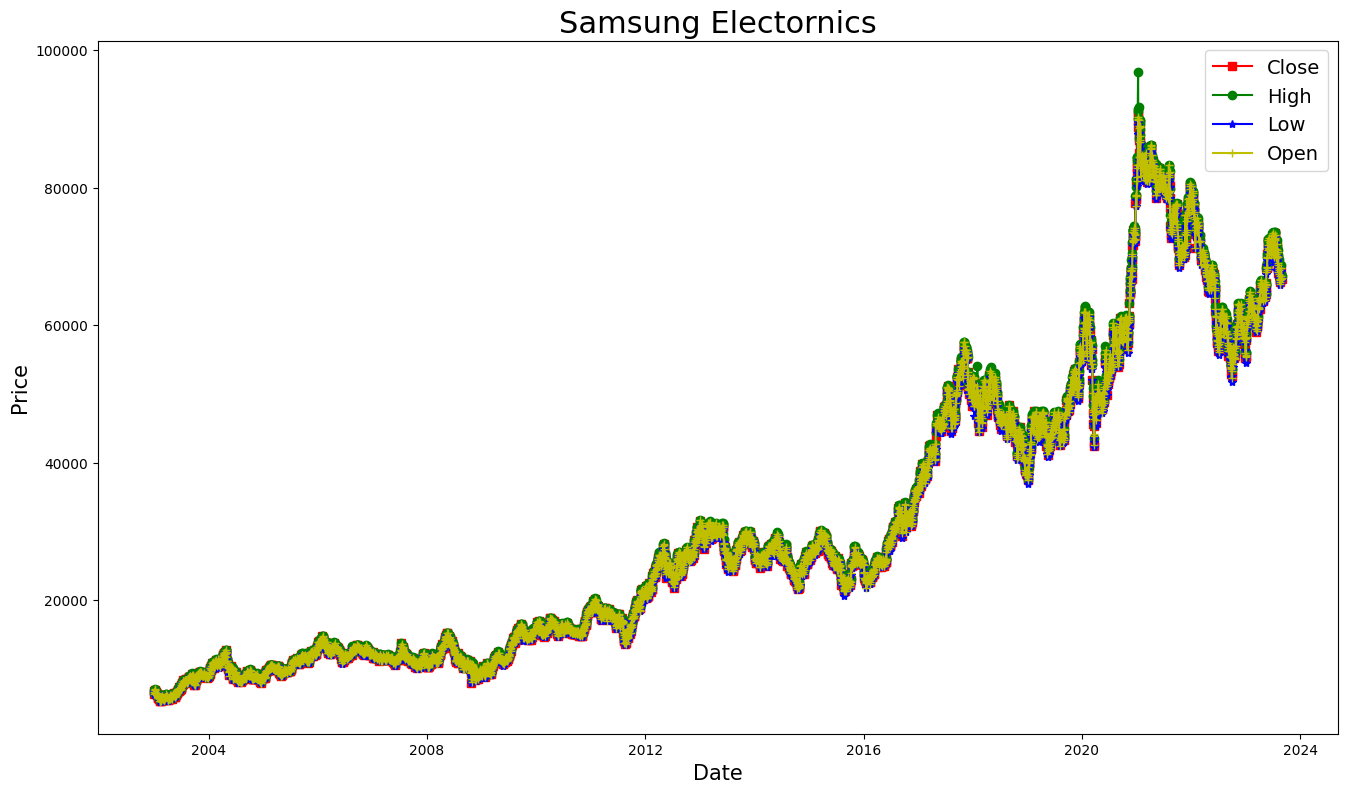

In [ ]:
# 일자 데이터를 2023-08-29 등의 형태로 설정

df_price['Date'] = pd.to_datetime(df_price['Date'], format='%Y-%m-%d')
df_price['Year'] =df_price['Date'].dt.year
df_price['Month'] =df_price['Date'].dt.month
df_price['Day'] =df_price['Date'].dt.day

# 일자 데이터 정렬
print(df_price['Date'])

# 데이터 안에 NaN 등의 숫자가 아닌 값이 있는지 확인한다. 해당 데이터는 모두 숫자로만 이루어진 값!
df_price.isna().sum()

print("삭제 전 데이터 수:",len(df_price))
df_price = df_price.dropna(axis=0).reset_index(drop=True)

print("삭제 후 데이터 수:",len(df_price))
df_price.isna().sum()

# 해당 데이터는 자체 제작시 이미 정합성 검사를 거쳤기 때문에 삭제되는 값은 없음.
# 하지만 이상치 분석을 위해선 먼저 데이터 자체의 신뢰도가 보장되어야 하기에
# (원래 데이터는 이상없으나 데이터파일의 결함 등으로...) 해당 부분 추가함.

# 주식그래프 시각화
plt.rcParams["figure.figsize"] = (16,9)

# 종가, 고가, 저가, 개장가격 각각 부여
plt.plot(df_price.Date, df_price.Close, marker='s', color='r')
plt.plot(df_price.Date, df_price.High, marker='o', color='g')
plt.plot(df_price.Date, df_price.Low, marker='*', color='b')
plt.plot(df_price.Date, df_price.Open, marker='+', color='y')

plt.title('Samsung Electornics', fontsize=22)
plt.ylabel('Price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.legend(['Close', 'High', 'Low', 'Open'], fontsize=14, loc='best')

plt.show()

In [ ]:
# 데이터 전처리
# 해당 코드는 주어진 시계열 데이터의 특징을 분해하기 위해 시계열 분해 기법인 seasonal_decompose를 활용하여
# 데이터를 트렌드(trend), 계절적 요인(seasonal), 그리고 잔차(residual) 세 부분으로 분해하는 과정.
# 이유 : 진짜 '이상치' 라고 간주될 만한 잔차 부분을 얻기 위함!!
def my_decompose(df_data, features, freq=50):
    trend = pd.DataFrame()      # 트렌드
    seasonal = pd.DataFrame()   # 계절적 요인
    resid = pd.DataFrame()      # 잔차

    # 사용할 feature 마다 decompose를 수행한다.
    for f in features:
        result = seasonal_decompose(df_data[f], model='additive', period=freq, extrapolate_trend=freq)
        trend[f] = result.trend.values
        seasonal[f] = result.seasonal.values
        resid[f] = result.resid.values

    return trend, seasonal, resid

In [ ]:
# 각 변수별 트렌드/계절적/잔차
tdf, sdf, rdf = my_decompose(df_price, features=['Open','High','Low','Close','Volume'])
print(rdf)

# 데이터의 크기에 따른 오차를 줄이기 위해 표준정규화
scaler = StandardScaler()
scaler.fit(rdf)

# 구한 잔차 데이터를 표준정규화 하고 처리
norm_rdf = scaler.transform(rdf)

# k-means 알고리즘으로 클러스터 분리
kmeans = KMeans(n_clusters=20, random_state=0, n_init=10).fit(norm_rdf)
lbl, cnt = np.unique(kmeans.labels_,return_counts=True,)
['group:{}-count:{}'.format(group, count) for group, count in zip(lbl, cnt)]

             Open         High          Low        Close        Volume
0      673.689265   669.114777   730.326469   757.264417 -1.035529e+07
1     1017.521456  1198.535684  1071.058628  1156.802868  1.895568e+07
2     1148.706589  1123.057572  1255.350590  1170.993279 -1.267353e+07
3     1384.244662  1279.487303  1152.145493  1070.192514 -8.044728e+06
4     1139.206266  1096.917034  1128.161966  1050.264297 -1.109771e+07
...           ...          ...          ...          ...           ...
5081 -6708.178479 -6898.724078 -6399.658419 -6226.601579 -3.548636e+06
5082 -5167.331461 -5342.125327 -4961.365512 -5201.984448  2.084640e+06
5083 -6425.121698 -6688.075595 -6018.990251 -6334.533003 -6.495754e+06
5084 -6761.686444 -7174.161157 -6460.827736 -6699.747245 -8.811054e+06
5085 -6805.780603 -7078.732013 -6442.245613 -6776.591879 -4.106976e+06

[5086 rows x 5 columns]


['group:0-count:295',
 'group:1-count:518',
 'group:2-count:16',
 'group:3-count:343',
 'group:4-count:195',
 'group:5-count:476',
 'group:6-count:147',
 'group:7-count:6',
 'group:8-count:23',
 'group:9-count:279',
 'group:10-count:306',
 'group:11-count:68',
 'group:12-count:70',
 'group:13-count:54',
 'group:14-count:336',
 'group:15-count:504',
 'group:16-count:116',
 'group:17-count:139',
 'group:18-count:529',
 'group:19-count:666']

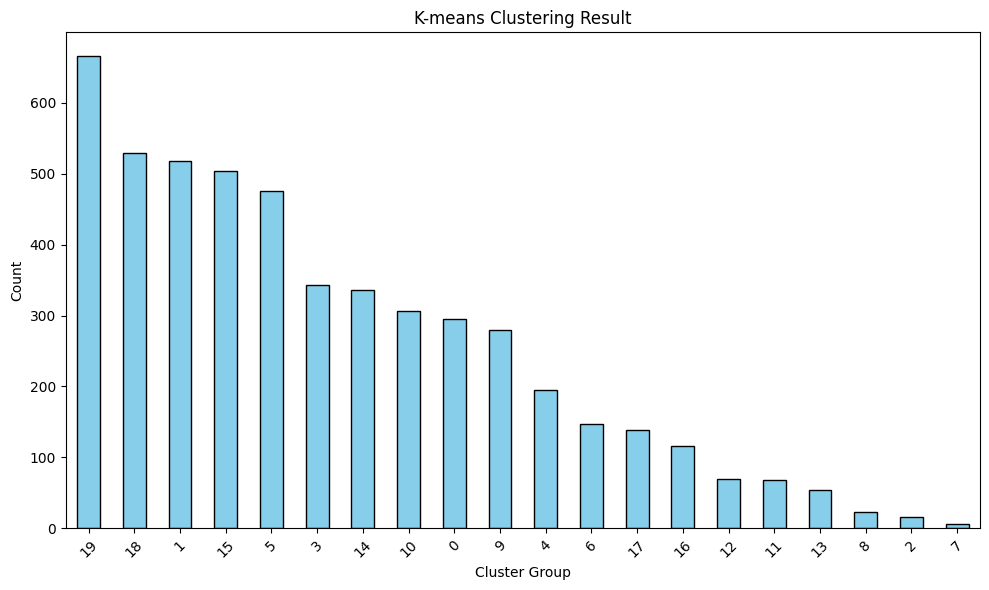

,Group,Count
7,7,6
2,2,16
8,8,23
13,13,54
11,11,68
12,12,70
16,16,116
17,17,139
6,6,147
4,4,195


In [ ]:
# 클러스터 결과를 DataFrame으로 변환
cluster_df = pd.DataFrame({
    'Group': lbl,
    'Count': cnt
})

# 정렬된 순서로 바 차트를 그린다.
cluster_df = cluster_df.sort_values(by='Count', ascending=False)
cluster_df.set_index('Group', inplace=True)

# 바 차트 시각화
plt.figure(figsize=(10, 6))
cluster_df['Count'].plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('K-means Clustering Result')
plt.ylabel('Count')
plt.xlabel('Cluster Group')
plt.xticks(rotation=45)
plt.tight_layout()

# 이미지로 저장
plt.savefig("cluster_result.png", dpi=300)
plt.show()

# 클러스터 결과를 DataFrame으로 변환
cluster_df = pd.DataFrame({
    'Group': lbl,
    'Count': cnt
})

# Count 기준으로 정렬
cluster_df = cluster_df.sort_values(by='Count', ascending=True)

# 배경색을 조절하는 함수
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

# 스타일링 적용
styled = cluster_df.style.apply(highlight_max, subset=['Count'])

# 스타일링된 결과를 이미지로 저장 (이 과정은 추가 라이브러리를 필요로 합니다.)
# styled.to_image("styled_cluster_result.png")

# Jupyter 노트북 환경에서 표시할 경우
styled

In [ ]:
# 특정 그룹 값 확인
print(df_price[(kmeans.labels_==2)])

# 각 그룹의 중심부는 어떤 값을 가지고 있는지 확인
pd.DataFrame(kmeans.cluster_centers_, columns=['Open','High','Low','Close','Volume'])

           Date   Open   High    Low  Close    Volume  Year  Month  Day
4245 2020-03-18  47750  48350  45600  45600  40152623  2020      3   18
4246 2020-03-19  46400  46650  42300  42950  56925513  2020      3   19
4247 2020-03-20  44150  45500  43550  45400  49730008  2020      3   20
4248 2020-03-23  42600  43550  42400  42500  41701626  2020      3   23
4249 2020-03-24  43850  46950  43050  46950  49801908  2020      3   24
5075 2023-08-14  67500  67900  66900  67300   9352343  2023      8   14
5076 2023-08-16  66700  67100  66300  67000  13174578  2023      8   16
5077 2023-08-17  66300  66800  66000  66700  10778652  2023      8   17
5078 2023-08-18  66000  66700  65800  66300  11745006  2023      8   18
5079 2023-08-21  66600  67100  66300  66600   9720067  2023      8   21
5080 2023-08-22  67200  67700  66300  66600  10500242  2023      8   22
5081 2023-08-23  66700  67100  66400  67100   9549352  2023      8   23
5082 2023-08-24  68300  68700  67900  68200  15044463  2023     

,Open,High,Low,Close,Volume
0,-0.666640,-0.594201,-0.686221,-0.625831,0.508663
1,0.489712,0.469604,0.550647,0.515361,-0.568146
2,-5.460561,-5.493809,-5.667416,-5.463134,0.529087
3,0.076226,0.029917,0.104158,0.065973,-1.428502
4,1.905237,1.898721,1.933594,1.890456,-0.044781
5,0.318487,0.343081,0.303886,0.326875,0.284488
6,-1.995276,-1.956198,-1.955032,-1.896731,0.059466
7,6.443829,8.001475,6.532756,7.119567,2.713744
8,0.231153,0.592396,0.233934,0.428369,5.391013
9,-1.144812,-1.205426,-1.134131,-1.187170,-0.279216


In [ ]:
# 데이터와 레이블 로드
# (실제 데이터 로드 코드에 따라 아래 줄의 내용이 변경될 수 있습니다.)
# norm_rdf: 표준정규화된 데이터
# kmeans.labels_: k-means에서 반환된 레이블

# 2D 플롯으로 표현하기 위해 두 개의 주요 특성 선택 (예: 'Open'과 'Close')
x_1 = norm_rdf[:, 0]  # 'Open'에 해당하는 데이터
x_2 = norm_rdf[:, 3]  # 'Close'에 해당하는 데이터
x_3 = norm_rdf[:, 4]  # 'Volume'에 해당하는 데이터

print(norm_rdf)

# 클러스터 중심
centers = kmeans.cluster_centers_

[[ 0.57717826  0.57950821  0.64180988  0.64990228 -1.44777076]
 [ 0.86448345  1.02650111  0.93449072  0.98520291  2.65290365]
 [ 0.97410137  0.96277454  1.09279315  0.99711179 -1.77209827]
 ...
 [-5.35456775 -5.63220695 -5.15569314 -5.30167558 -0.90781285]
 [-5.63580029 -6.04261159 -5.53522106 -5.60817065 -1.23172877]
 [-5.67264524 -5.96204025 -5.51925945 -5.6726602  -0.5736172 ]]


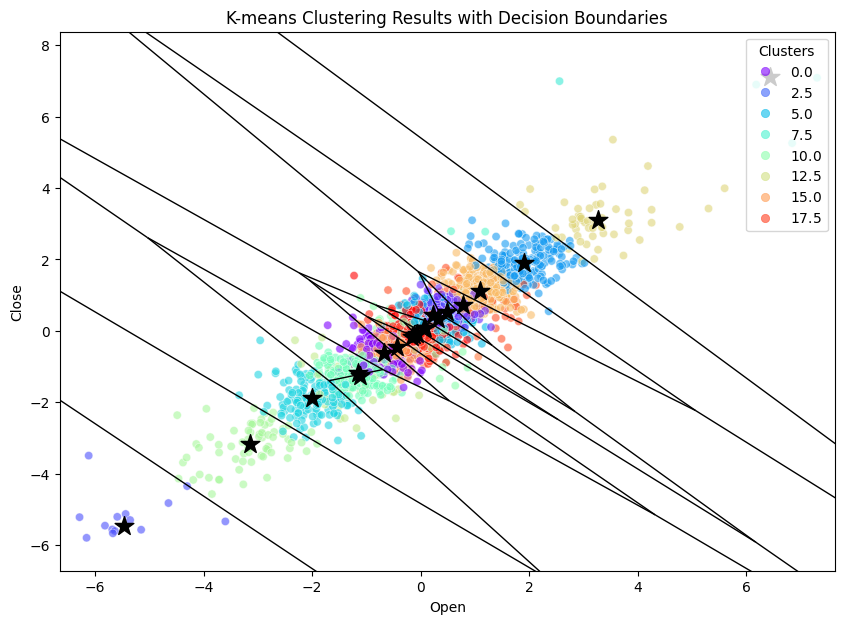

In [ ]:
# 시각화 1

vor = Voronoi(centers[:, [0, 3]])

# 시각화
plt.figure(figsize=(10, 7))
voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=plt.gca())

scatter = plt.scatter(x_1, x_2, c=kmeans.labels_, cmap='rainbow', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.scatter(centers[:, 0], centers[:, 3], marker='*', s=200, c='black')

# legend 추가
handles, labels = scatter.legend_elements()
legend1 = plt.legend(handles, labels, loc="upper right", title="Clusters")

plt.xlabel('Open')
plt.ylabel('Close')
plt.title('K-means Clustering Results with Decision Boundaries')
plt.show()

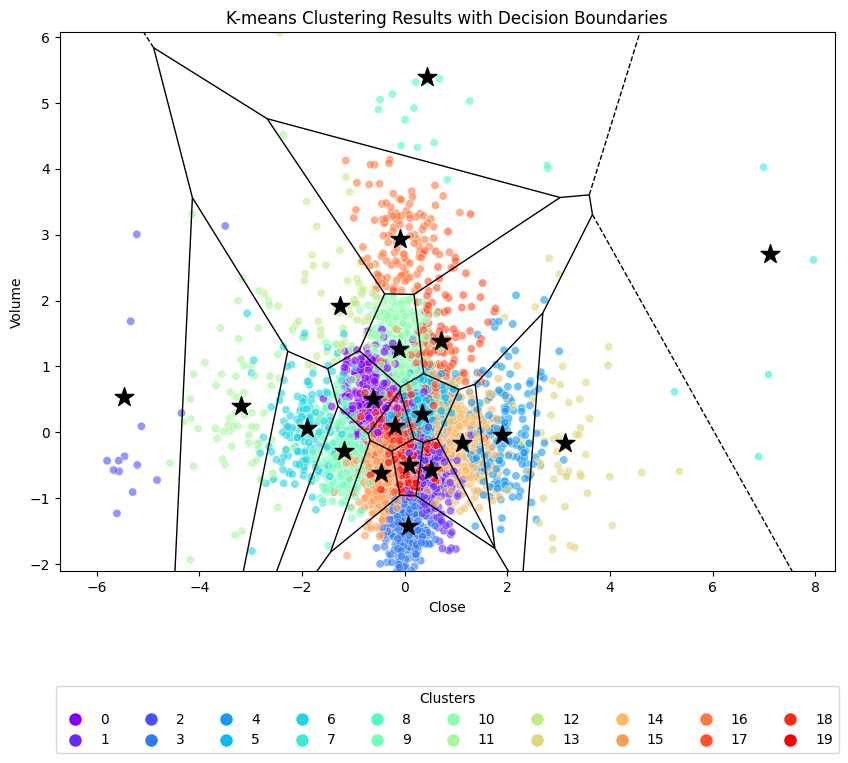

In [ ]:
# 데이터 로드
x_2 = norm_rdf[:, 3]  # 'Close'에 해당하는 데이터
x_3 = norm_rdf[:, 4]  # 'Volume'에 해당하는 데이터

# Voronoi diagram으로 클러스터 중심에 따른 영역을 구분
vor = Voronoi(centers[:, [3, 4]])

# 시각화
plt.figure(figsize=(10, 7))
voronoi_plot_2d(vor, show_vertices=False, show_points=False, ax=plt.gca())

scatter = plt.scatter(x_2, x_3, c=kmeans.labels_, cmap='rainbow', alpha=0.6, edgecolors='w', linewidth=0.5)
plt.scatter(centers[:, 3], centers[:, 4], marker='*', s=200, c='black')

# legend 추가
labels = [str(i) for i in range(20)]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(i)), markersize=10) for i in range(20)]
legend1 = plt.legend(handles, labels, loc="lower center", ncol=10, title="Clusters", bbox_to_anchor=(0.5, -0.35))

plt.xlabel('Close')
plt.ylabel('Volume')
plt.title('K-means Clustering Results with Decision Boundaries')
plt.show()